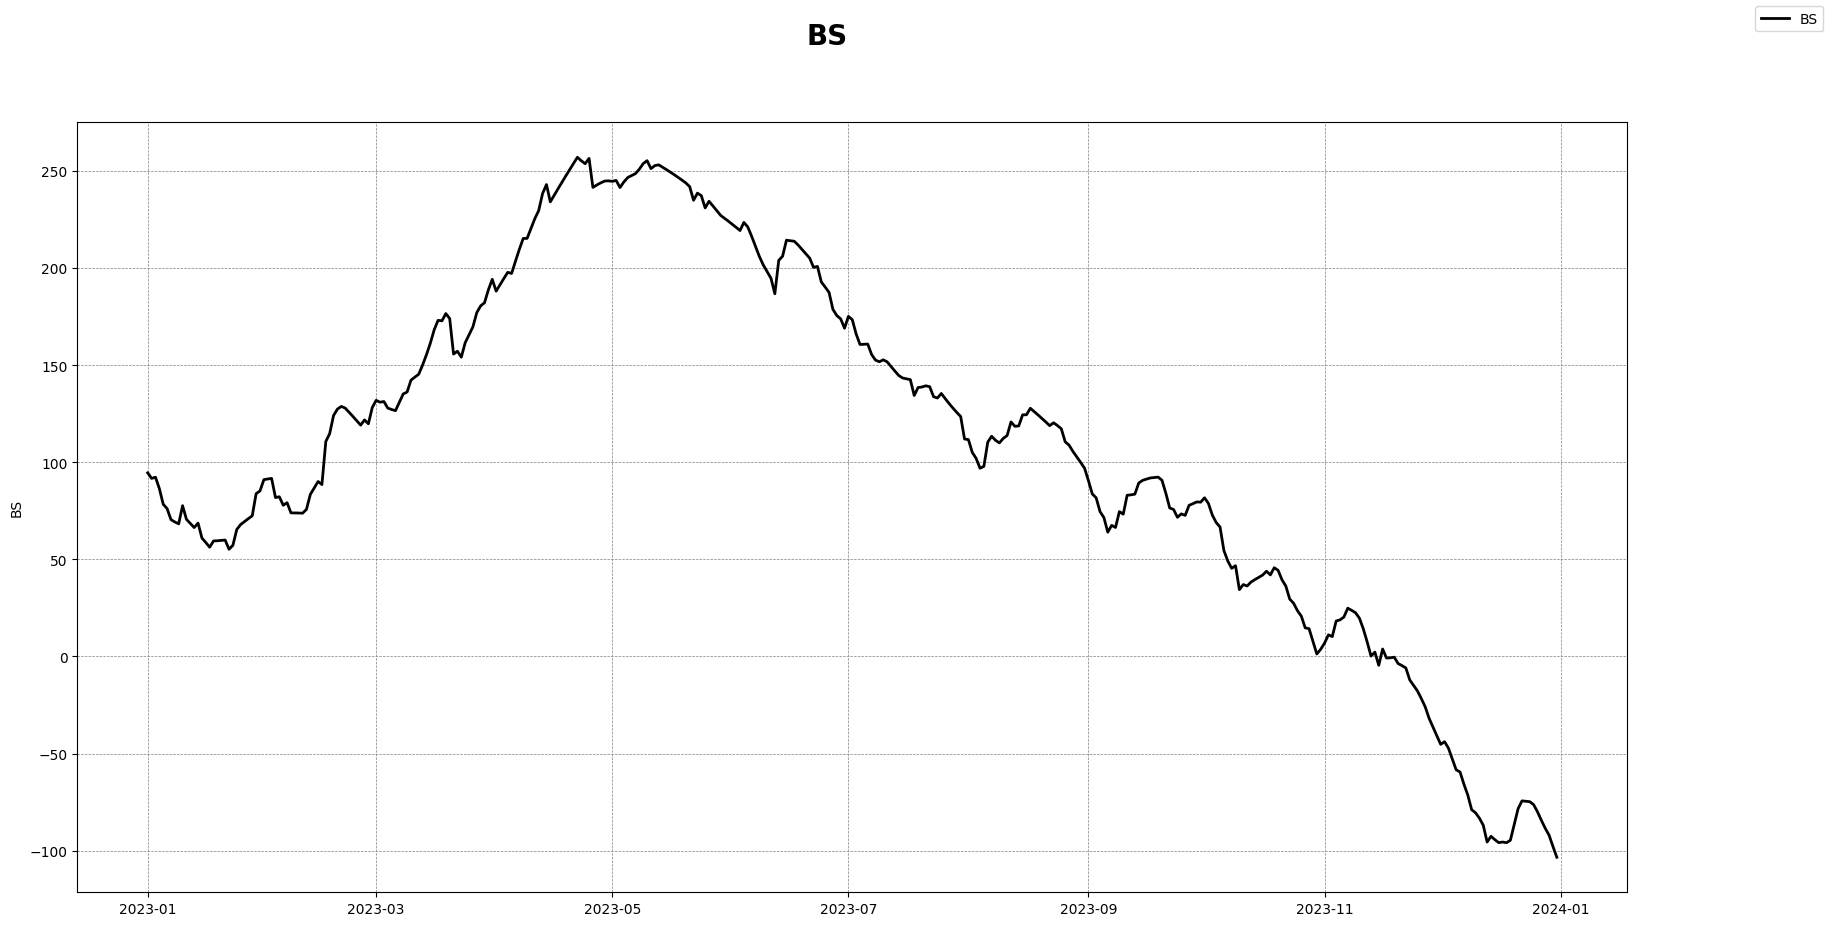

In [2]:
# !pip install --user pyswisseph

import swisseph as swe
import datetime
from typing import Dict, List, Tuple, Callable, Optional
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import combinations
from functools import reduce
import re

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------
center = 'geocentric'
# center = 'heliocentric'
# center = 'planetocentric'
center_planet = swe.EARTH

mid_term_combinations = [    ('Mercury', 'Pluto'),    ('Mercury', 'Neptune'),    ('Mercury', 'Uranus'),    ('Mercury', 'Saturn'),    ('Mercury', 'Jupiter'),    ('Mercury', 'Mars'),    ('Mercury', 'Sun'),    ('Mercury', 'Venus'),    ('Venus', 'Pluto'),    ('Venus', 'Neptune'),    ('Venus', 'Uranus'),    ('Venus', 'Saturn'),    ('Venus', 'Jupiter'),    ('Venus', 'Mars'),    ('Sun', 'Pluto'),    ('Sun', 'Neptune'),    ('Sun', 'Uranus'),    ('Sun', 'Saturn'),    ('Sun', 'Jupiter'),    ('Sun', 'Venus'),    ('Mars', 'Pluto'),    ('Mars', 'Neptune'),    ('Mars', 'Uranus'),    ('Mars', 'Saturn'),    ('Mars', 'Sun'),    ('Mars', 'Jupiter')]
long_term_combinations = [    ('Jupiter', 'Pluto'),    ('Jupiter', 'Neptune'),    ('Jupiter', 'Uranus'),    ('Jupiter', 'Saturn'),    ('Saturn', 'Pluto'),    ('Saturn', 'Neptune'),    ('Saturn', 'Uranus'),    ('Uranus', 'Pluto'),    ('Uranus', 'Neptune'),    ('Neptune', 'Pluto'),]

valency_data = [
    [ 1,  1,  1,  1, -1,  1, -1, -1,  1, -1], 
    [ 1,  1,  1,  1, -1,  1, -1,  1, -1, -1], 
    [ 1,  1,  1,  1, -1,  1, -1,  1,  1, -1], 
    [ 1,  1,  1,  1, -1,  1, -1,  1,  1,  1], 
    [-1, -1, -1, -1,  1, -1, -1, -1, -1, -1], 
    [ 1,  1,  1,  1, -1,  1, -1, -1,  1, -1], 
    [-1, -1, -1, -1, -1, -1,  1, -1, -1, -1], 
    [-1,  1,  1,  1, -1, -1, -1,  1, -1, -1], 
    [ 1, -1,  1,  1, -1,  1, -1, -1,  1, -1], 
    [-1, -1, -1,  1, -1, -1, -1, -1, -1,  1], 
]

valency = pd.DataFrame(valency_data, index=[ "moon", "sun", "mercury", "venus", "mars", "jupiter", "saturn", "uranus", "neptune", "pluto"], columns=['moon', 'sun', 'mercury', 'venus', 'mars', 'jupiter', 'saturn', 'uranus', 'neptune', 'pluto'])

# planets = [swe.VENUS, swe.URANUS]

# planets = [swe.MERCURY, swe.VENUS, swe.MARS, swe.JUPITER, swe.SATURN, swe.URANUS, swe.NEPTUNE, swe.PLUTO]

# planets = [swe.SUN, swe.MERCURY, swe.VENUS, swe.MARS, swe.JUPITER, swe.SATURN, swe.URANUS, swe.NEPTUNE, swe.PLUTO]

planets = [swe.SUN, swe.MOON, swe.MERCURY, swe.VENUS, swe.MARS, swe.JUPITER, swe.SATURN, swe.URANUS, swe.NEPTUNE, swe.PLUTO]

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------
def calculate_julian_day(date: datetime.date) -> float:
    return swe.julday(date.year, date.month, date.day)

def generate_dates(start_date: datetime.date, end_date: datetime.date) -> List[datetime.date]:
    delta = end_date - start_date
    return list(map(lambda i: start_date + datetime.timedelta(days=i), range(delta.days + 1)))

def calculate_julian_days(start_date: datetime.date, end_date: datetime.date) -> Dict[datetime.date, float]:
    date_range = generate_dates(start_date, end_date)
    julian_days = dict(zip(date_range, map(calculate_julian_day, date_range)))
    return julian_days

start_date = datetime.date(2023, 1, 1)
end_date = datetime.date(2023, 12, 31)

julian_days = calculate_julian_days(start_date, end_date)

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------
def calculate_planetary_longitudes(julian_day: float, mode: str = 'geocentric') -> Dict[str, float]:
    def get_longitude(planet: int) -> Dict[str, float]:
        if mode == 'geocentric':
            position, ret_code = swe.calc_ut(julian_day, planet, flags=swe.FLG_SWIEPH|swe.FLG_SIDEREAL)
        elif mode == 'heliocentric':
            position, ret_code = swe.calc_ut(julian_day, planet, flags=swe.FLG_SWIEPH|swe.FLG_SIDEREAL|swe.FLG_HELCTR)
        elif mode == 'planetocentric':
            if planet != center_planet:
                position, ret_code = swe.calc_pctr(julian_day, planet, center=center_planet, flags=swe.FLG_SWIEPH|swe.FLG_SIDEREAL)
            else:
                return {}  # Return an empty dictionary if the planet and center are the same
        else:
            raise ValueError("Invalid mode. Accepted values are 'geocentric', 'heliocentric', or 'planetocentric'.")

        return {swe.get_planet_name(planet) + "_Longitude": position[0]}

    longitudes = {k: v for d in map(get_longitude, planets) for k, v in d.items()}

    return longitudes

def calculate_all_longitudes(julian_days: Dict[datetime.date, float], mode: str = 'geocentric') -> Dict[datetime.date, Dict[str, float]]:
    return dict(map(lambda date_jd: (date_jd[0], calculate_planetary_longitudes(date_jd[1], mode)), julian_days.items()))

# Calculate the geocentric longitudes for all planets for each day
planetary_longitudes = calculate_all_longitudes(julian_days, mode=center)

# Convert to DataFrame format
df_planetary_longitudes = pd.DataFrame.from_dict(planetary_longitudes, orient='index')
df_planetary_longitudes.index.name = 'timestamp'
df_planetary_longitudes.reset_index(inplace=True)
df_planetary_longitudes.set_index('timestamp', inplace=True)

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------
def calculate_planetary_declinations(julian_day: float, mode: str = 'geocentric') -> Dict[str, float]:
    planets = [swe.VENUS, swe.MARS]
    # planets = [swe.MERCURY, swe.MARS]
    # planets = [swe.SUN, swe.MERCURY, swe.VENUS, swe.MARS, swe.JUPITER, swe.SATURN, swe.URANUS, swe.NEPTUNE, swe.PLUTO]

    def get_declination(planet: int) -> Tuple[str, float]:
        if mode == 'geocentric':
            position, ret_code = swe.calc_ut(julian_day, planet, flags=swe.FLG_SWIEPH|swe.FLG_EQUATORIAL|swe.FLG_SIDEREAL)
        elif mode == 'heliocentric':
            position, ret_code = swe.calc_ut(julian_day, planet, flags=swe.FLG_SWIEPH|swe.FLG_EQUATORIAL|swe.FLG_SIDEREAL|swe.FLG_HELCTR)
        elif mode == 'planetocentric':
            if planet != center_planet:
                position, ret_code = swe.calc_pctr(julian_day, planet, center=center_planet, flags=swe.FLG_SWIEPH|swe.FLG_EQUATORIAL|swe.FLG_SIDEREAL)
                # print(position)
            else:
                return {}  # Return an empty dictionary if the planet and center are the same
        else:
            raise ValueError("Invalid mode. Accepted values are 'geocentric', 'heliocentric', or 'planetocentric'.")

        return {swe.get_planet_name(planet) + "_Declination": position[1]}

    declinations = {k: v for d in map(get_declination, planets) for k, v in d.items()}

    return declinations

def calculate_all_declinations(julian_days: Dict[datetime.date, float], mode: str = 'geocentric') -> Dict[datetime.date, Dict[str, float]]:
    return dict(map(lambda date_jd: (date_jd[0], calculate_planetary_declinations(date_jd[1], mode)), julian_days.items()))

# Calculate the geocentric declinations for all planets for each day
planetary_declinations = calculate_all_declinations(julian_days, mode=center)

# Convert to DataFrame format
df_planetary_declinations = pd.DataFrame.from_dict(planetary_declinations, orient='index')
df_planetary_declinations.index.name = 'timestamp'
df_planetary_declinations.reset_index(inplace=True)
df_planetary_declinations.set_index('timestamp', inplace=True)
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------
def create_aspect(aspect: int, planetary_longitudes: pd.DataFrame, valency: pd.DataFrame) -> pd.DataFrame:
    def calc_amplitude(delta_longitude: float, planet1: str, planet2: str) -> float:
        delta = np.abs(delta_longitude - aspect)
        if delta <= 15:
            amplitude = 10 - delta
            if aspect == 0:
                amplitude *= valency.at[planet1.lower(), planet2.lower()]
        else:
            amplitude = 0
        return amplitude

    planet_combinations = list(combinations(planetary_longitudes.columns, 2))

    aspect_data = [pd.DataFrame({
        f"{pair[0].split('_')[0]}_{pair[1].split('_')[0]}_{aspect}": 
        np.abs(planetary_longitudes[pair[0]] - planetary_longitudes[pair[1]]).apply(
            calc_amplitude, args=(pair[0].split('_')[0], pair[1].split('_')[0]))})
        for pair in planet_combinations]

    return pd.concat(aspect_data, axis=1)

# Calculate aspects for each aspect angle (0, 60, 90, 120, and 180 degrees)
aspects = [0, 60, 90, 120, 180]
df_aspects = [create_aspect(aspect, df_planetary_longitudes, valency) for aspect in aspects]

# Combine all aspect DataFrames
df_all_aspects = pd.concat(df_aspects, axis=1)


# ----------------------------------------------------------------------------------------------------------------------------------------------------------------
def calculate_influence_vectorized(df_all_aspects: pd.DataFrame, combinations: List[Tuple[str, str]]) -> pd.Series:
    def get_matching_columns(combo: Tuple[str, str]) -> pd.Index:
        pattern = re.compile(f"{combo[0]}_{combo[1]}_\\d+")  # pattern to match any aspect involving the planets in the current combination
        matching_cols = df_all_aspects.columns[df_all_aspects.columns.str.match(pattern)]
        return matching_cols
    
    def add_influence(acc: pd.Series, matching_cols: pd.Index) -> pd.Series:
        return acc.add(df_all_aspects.loc[:, matching_cols].sum(axis=1), fill_value=0)
    
    matching_columns = map(get_matching_columns, combinations)
    influence_values = reduce(add_influence, matching_columns, pd.Series(index=df_all_aspects.index, dtype=float).fillna(0))
    
    return influence_values

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------
def calculate_p(df_all_aspects: pd.DataFrame, mid_term_combinations: List[Tuple[str, str]], long_term_combinations: List[Tuple[str, str]], planetary_declinations: pd.DataFrame) -> np.ndarray:
    # Calculate M
    M = calculate_influence_vectorized(df_all_aspects, mid_term_combinations)

    # Calculate L
    L = calculate_influence_vectorized(df_all_aspects, long_term_combinations)

    # Calculate D
    D = planetary_declinations.sum(axis=1)

    # Calculate X
    X = 4

    # Calculate P
    P = M.add((L.add(D)).multiply(X))

    return P

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------

P = calculate_p(df_all_aspects, mid_term_combinations, long_term_combinations, df_planetary_declinations)

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------

# Create a figure with three subplots that share the same x-axis
fig, ax = plt.subplots(figsize=(20,10), sharex=True)

ax.plot(P, linewidth=2, color="black", label="BS")
ax.set_ylabel('BS', color='black')

# Set a title for the entire figure
fig.suptitle('BS', fontsize=20, fontweight="bold")

# Set a grid on all three axes
grid_style = {'linewidth': 0.5, 'color': 'gray', 'linestyle': '--'}
ax.grid(True, **grid_style)


# Add a legend for all three axes
lines, labels = ax.get_legend_handles_labels()


fig.legend(lines, labels, loc='upper right')

plt.savefig('BS.png', dpi=300, bbox_inches='tight')

plt.show()